In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from nilearn.plotting import plot_design_matrix
import statsmodels.api as sm

sys.path.append('/Users/jeanettemumford/Dropbox/Research/Projects/patrick/efficiency_rdoc')

from utils import (calc_expected_run_num_by_chance, sample_shifted_truncated_exponential, 
                   est_eff_and_vif, est_psych_fitness, run_eff_sim)

## Visual Search

The task layout we're starting with is the following:

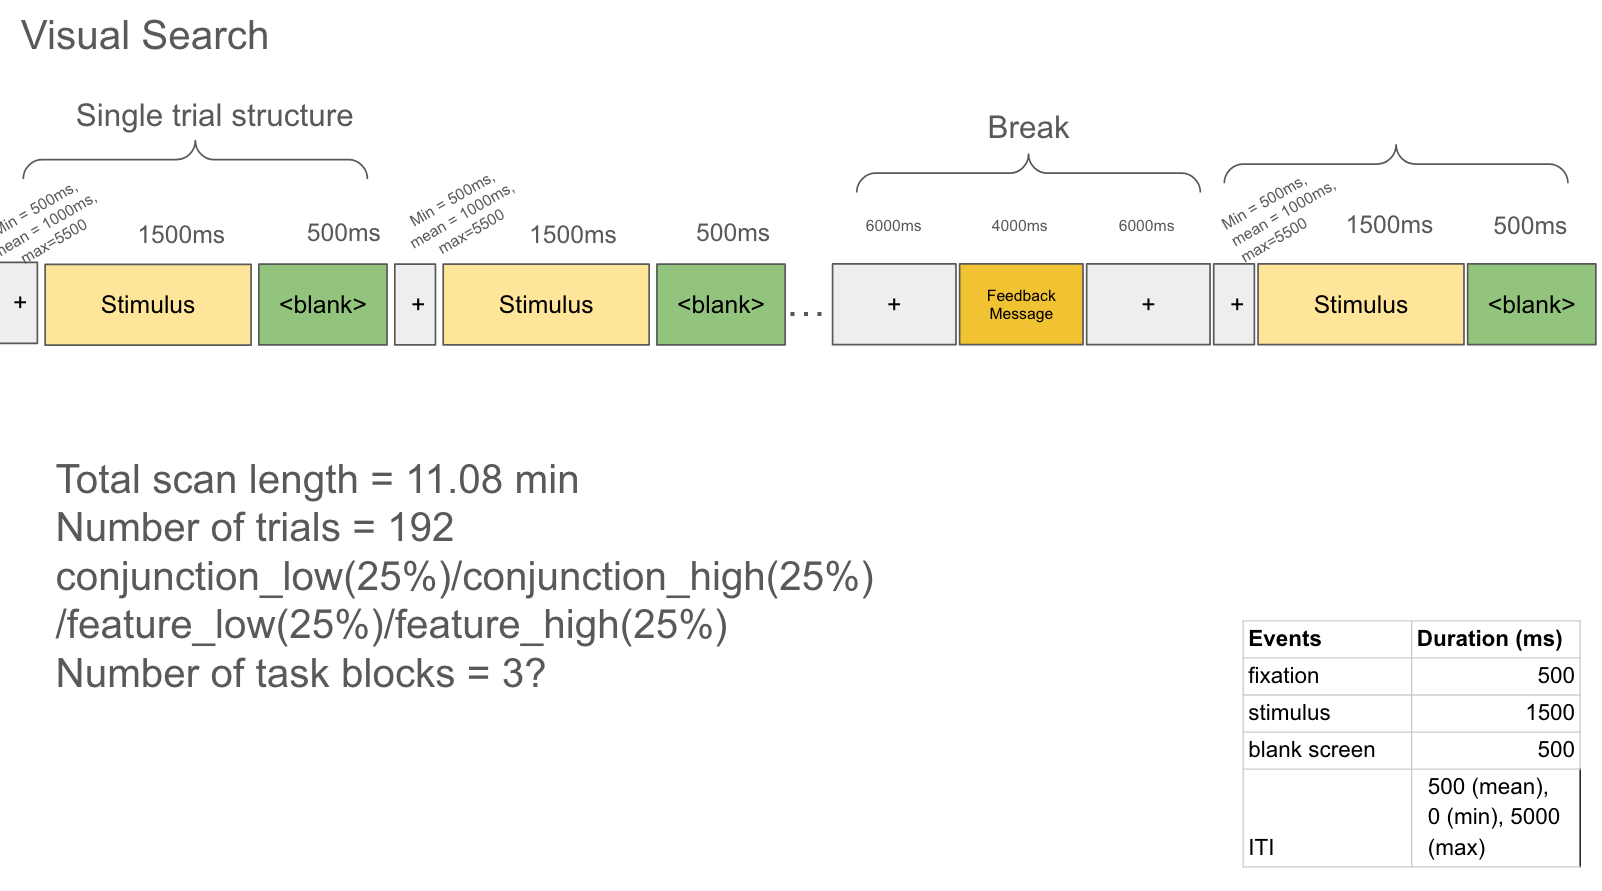

In [2]:
def make_visual_search_timings(n_con_high, n_con_low, n_feat_high, n_feat_low, stim_dur, blank_dur,  
                             nbreaks, break_fix_pre_message_dur, break_message_dur,  
                             break_fix_post_message_dur, isi_exp_lam, isi_truncation, 
                             isi_shift):
    '''
    Produces a randomly ordered set of trials for the visual search tasks.
    Assumes a break between blocks of task.  Number of con_high/con_low/feat_high/feat_low trials will be equal
    for each block of the task 
    ISI is sampled from a truncated exponential.  Note the truncation value for the
    truncated exponential does *not* include the shift, so the max isi is
    isi_truncation + isi_shift.
    A trial is structured as:
      fixation (based on truncated exponential) + 
      stimulus (stim_dur) + blank (blank_dur) + 
      next trial (same structure as above until end of block is reached)
      At end of block the break begins with:
      fixation (length=break_dur) + 
      break message (break_message_dur) + 
      post message fixation (post_message_dur)
    Input:
      n_con_high, n_con_low, n_feat_high, n_feat_low: Total number of con_high/con_low/feat_high/feat_low trials 
          (will be evenly split between blocks) Integer divisible by (nbreaks + 1)
      stim_dur/blank_dur: Durations of stim/blank
      break_fix_pre_message_dur: Fixation duration at beginning of break (no jittering)
      break_message_dur:  Duration of message shown during break
      break_fix_post_message_dur:  Fixation duration after message (no jittering)
      isi_exp_lam:  (seconds) The lambda parameter of the exponential used for the isi 
                    (inverse is the non-truncated/non-shifted mean)
      isi_truncation: (seconds) Truncation value of the exponential *NOT* including shift.  
                      Max ISI = isi_truncation + isi_shift
      isi_shift: (seconds) Shift value for isi (minimum isi value)
    Output:
       Events pandas data frame with onsets, trial_type and duration.  
    '''
    
    nblocks = nbreaks + 1
    ntrials = n_con_high + n_con_low + n_feat_high + n_feat_low
    ntrials_per_block = int(ntrials/nblocks)
    n_con_high_per_block = int(n_con_high/ (nblocks))
    n_con_low_per_block = int(n_con_low / (nblocks))
    n_feat_high_per_block = int(n_feat_high/ (nblocks))
    n_feat_low_per_block = int(n_feat_low / (nblocks))
    isi_vals, _ = sample_shifted_truncated_exponential(isi_exp_lam, isi_truncation, 
                                                    isi_shift, ntrials)

    # fragments = all sub-components of the run (go/stop/fixation/blank/break_message)
    # Each stimulus has 3 fragments and each break has 3 fragments
    isi_count = 0
    fragment_durations = []
    fragment_labels = []
    for cur_block in range(nblocks):
        stim_type_block = np.random.permutation(np.concatenate((np.repeat(['con_high'], n_con_high_per_block),
                                                        np.repeat(['con_low'], n_con_low_per_block),
                                                        np.repeat(['feat_high'], n_feat_high_per_block),
                                                        np.repeat(['feat_low'], n_feat_low_per_block))))
        # add in starter trial (n/a trial)
        stim_type_block = np.insert(stim_type_block,0, ['start'])
        for cur_trial in range(ntrials_per_block):
            cur_stim_type = stim_type_block[cur_trial]
            fragment_durations.extend([isi_vals[isi_count], stim_dur, blank_dur])
            fragment_labels.extend(['isi_fix', cur_stim_type, 'blank'])
            isi_count = isi_count + 1
        #Add break
        fragment_durations.extend([break_fix_pre_message_dur, break_message_dur, break_fix_post_message_dur])
        fragment_labels.extend(['fix_break', 'break_message', 'fix_break'])

    # If you don't want the beginning of the run to start at 0, change this 
    # (e.g. if you want to add the 10s to reach steady state)
    run_start = 0
    fragment_onsets = np.cumsum([run_start] + fragment_durations)[:-1]       
    events_data = pd.DataFrame({'onset': fragment_onsets,
                                'trial_type': fragment_labels,
                                'duration': fragment_durations})
    events_data = events_data.loc[events_data['trial_type'].str.contains('con|feat|break_message')==True]
    return events_data

In [3]:
events_inputs = {
    'n_con_high': 48,
    'n_con_low': 48, 
    'n_feat_high': 48, 
    'n_feat_low': 48,
    'nbreaks': 2,
    'stim_dur': 1.5,
    'blank_dur': .5,
    'break_fix_pre_message_dur': 6,
    'break_message_dur': 4,
    'break_fix_post_message_dur': 6,
    'isi_exp_lam': 2,
    'isi_truncation': 4.5,
    'isi_shift': .5
}

tr = 1.49
total_time = 12*60
contrasts = {'conj-feat': '(.5*con_high + .5*con_low) - (.5*feat_high + .5*feat_low)',
             'conj_high-conj_low': 'con_high-con_low',
             'all_task': '.25*con_high + .25*con_low + .25*feat_high + .25*feat_low' 
             }

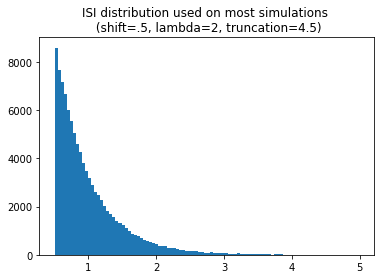

theoretical mean
0.9994445873382422
quartiles
[0.5   0.644 0.845 1.192 4.986]


In [4]:
nsamp = 100000 
samples, theoretical_mean = sample_shifted_truncated_exponential(events_inputs['isi_exp_lam'], events_inputs['isi_truncation'], 
                                                                 events_inputs['isi_shift'], nsamp)
isi_quartiles = np.round(np.quantile(samples, [0, .25, .5, .75, 1]), 3)

plt.hist(samples, 100)
plt.title('ISI distribution used on most simulations \n (shift=.5, lambda=2, truncation=4.5)')
plt.show()
print('theoretical mean')
print(theoretical_mean)
print('quartiles')
print(isi_quartiles)

In [5]:

trials_psych_assess_map = {'con_high': '1', 'con_low': '2', 'feat_high': '3', 'feat_low': '4'}

unpermuted_trials = np.concatenate([np.repeat('1', events_inputs['n_con_high']/3), 
                                    np.repeat('2', events_inputs['n_con_low']/3),
                                    np.repeat('3', events_inputs['n_feat_high']/3),
                                    np.repeat('4', events_inputs['n_feat_low']/3)],
                                    axis=0)
avg_trial_repeats_info = calc_expected_run_num_by_chance(unpermuted_trials, nsims=5000)

for val in ['1', '2', '3', '4']:
    avg_trial_repeats_info[f'{val}_run_counts'] = avg_trial_repeats_info[f'{val}_run_counts'] * 3
print(avg_trial_repeats_info.loc[:25, :])

    run_length  1_run_counts  2_run_counts  3_run_counts  4_run_counts
0          1.0       27.4458       27.3840       27.4464       27.3180
1          2.0        6.7236        6.8382        6.8022        6.7500
2          3.0        1.5588        1.5012        1.5546        1.6038
3          4.0        0.3606        0.3366        0.3324        0.3510
4          5.0        0.0660        0.0744        0.0618        0.0618
5          6.0        0.0120        0.0186        0.0102        0.0144
6          7.0        0.0006        0.0030        0.0036        0.0006
7          8.0        0.0000        0.0000        0.0000        0.0006
8          9.0        0.0000        0.0000        0.0000        0.0000
9         10.0        0.0000        0.0000        0.0000        0.0000
10        11.0        0.0000        0.0000        0.0000        0.0000
11        12.0        0.0000        0.0000        0.0000        0.0000
12        13.0        0.0000        0.0000        0.0000        0.0000
13    

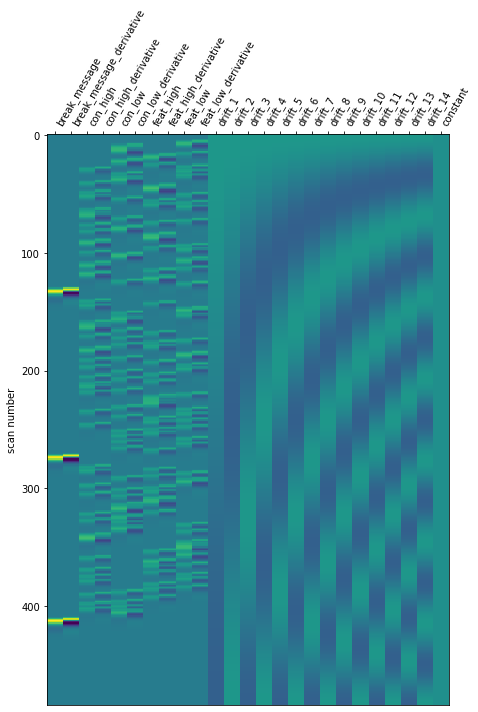

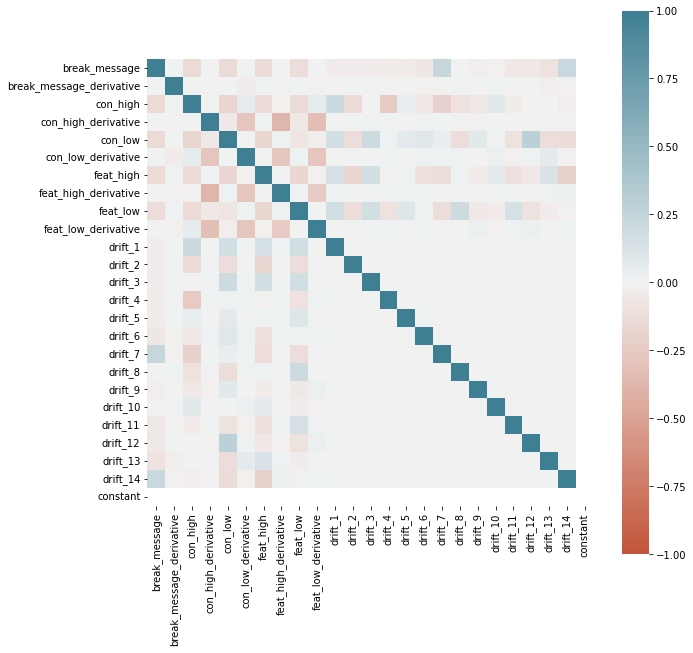

In [6]:
events_ts = make_visual_search_timings(**events_inputs)
_, _, desmat = est_eff_and_vif(events_ts, tr, total_time, contrasts)

plot_design_matrix(desmat)
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(
    desmat.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    ax=ax
)
plt.show()

In [7]:
nsim = 250
output_setting1, events_setting1 = run_eff_sim(nsim, events_inputs, make_visual_search_timings, 
                               contrasts, avg_trial_repeats_info, tr, total_time,
                               trials_psych_assess_map)

In [8]:
pd.set_option('display.width', 1000)
summary_names = [f'eff_{name}' for name in contrasts.keys()] + \
                [f'vif_{name}' for name in contrasts.keys()] + \
                ['scan_length']

eff_vif_summaries_gng = {}
eff_vif_summaries_gng['setting1']= np.round(output_setting1[summary_names].quantile(q=[.05, .5, .95]), 2)

for key, val in eff_vif_summaries_gng.items():
    print(f'Results for {key}')
    print(val)

Results for setting1
      eff_conj-feat  eff_conj_high-conj_low  eff_all_task  vif_conj-feat  vif_conj_high-conj_low  vif_all_task  scan_length
0.05           8.88                    4.52          4.42           1.07                    1.08          2.36       627.55
0.50          10.59                    5.25          5.01           1.14                    1.14          2.65       637.05
0.95          12.49                    6.35          5.75           1.28                    1.28          2.95       648.87
